# TP QP par un algorithme de points intérieurs

In [106]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC


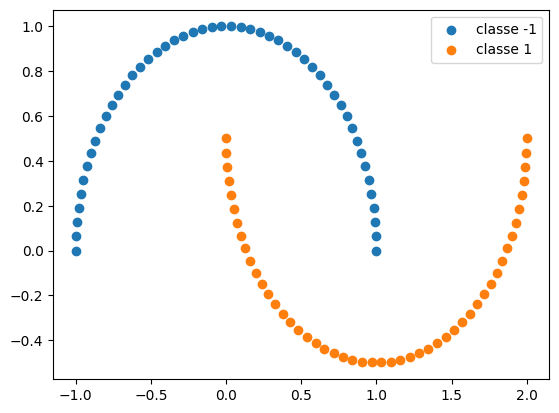

In [107]:
n_train = 100
X,y = make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)
y = np.where( y > .5, y, -1)
# afficher les données d'apprentissage sur un plot avec une couleur par classe
# inserer votre code ici

classes = np.unique(y)
for classe in classes:
    plt.scatter(X[y==classe,0], X[y==classe,1], label=f'classe {classe}')

plt.legend()
plt.show()

In [108]:
#%% SVM dual 
C =1000
N = X.shape[0]

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1
N = X.shape[0]
K = rbf_kernel(X,gamma = gamma)
yb = y.reshape(N,1)
P = K*(yb@yb.T)
q = -np.ones(N)

clf = SVC(C=C,kernel='precomputed')
clf.fit(K, y)
indice_SV = clf.support_
alpha_sk = clf.dual_coef_[0]
b_sk = clf.intercept_

# construire le vecteur solution alpha_0

# %% 
alpha_o = np.zeros(N)
alpha_o[indice_SV] = np.abs(alpha_sk)
print('cout opt',0.5*alpha_o.T@P@alpha_o + q.T@alpha_o)

# calculer la valeur objective optimale du problème QP obtenu par ce solveur SVM
# et afficher le résultat




cout opt -16.618676387290105


On s'interesse au problème
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } \alpha \geq 0
$$

In [109]:
# Algorithme de point intérieur 

# construction du problème et des matrices associés

q = -np.ones(N)
b = np.array([0.0])
A = y.reshape(1,N)

# initialization du point intérieur

alpha = np.random.rand(N)*1e-2
nb_constraint = A.shape[0]

ll = np.ones((nb_constraint,1)) # multiplicateur de Lagrange
s = ((P@alpha   + q).reshape(N,1) - A.T@ ll).reshape(N)
s = np.where(s < 0.000001, 1e-16, s)  # on garde que les parties positives pour que s soit faisable

print('cout init',0.5*alpha.T@P@alpha + q.T@alpha)


Id = np.eye(N)


cout init -0.5035155041054749


In [110]:
print(P.shape, A.T.shape, Id.shape)
print(A.shape, np.array([0]).shape, np.zeros((1, N)).shape)
print(np.diag(s).shape, np.zeros((N, 1)).shape, np.diag(alpha_o).shape)

(100, 100) (100, 1) (100, 100)
(1, 100) (1,) (1, 100)
(100, 100) (100, 1) (100, 100)


In [111]:
sigma = 0.5
x = np.copy(alpha)


for i in range(100):
    tau = x@s/N
    Sk = np.diag(s)
    Xk = np.diag(x)
    cout = 0.5*x.T@P@x + q.T@x
    # construire les lignes de la Jacobienne
    # inserer votre code ici
    J1 = np.hstack((P, -A.T, -np.eye(N)))
    J2 = np.hstack((A, np.array([[0]]), np.zeros((1, N))))
    J3 = np.hstack((np.diag(s), np.zeros((N, 1)), np.diag(x)))
    
    
    # construire la Jacobienne
    J = np.vstack((J1,J2,J3))  

    
    # construire les lignes du second membre
    b1 = (P@x + q - (A.T@ll).flatten() - s).reshape((N, 1))
    b2 = (A@x - b).reshape((1, 1))
    b3 = (Xk@s - sigma*tau*np.ones(N)).reshape((N, 1))

    
    second_membre = np.vstack((b1,b2,b3))
    
    # résoudre le problème
    J = J + 1e-6*np.eye(J.shape[0])
    S = np.linalg.solve(J, -second_membre)
    
    # extraire les directions pour chaque partie
    
    dx = S[:N].flatten()
    dy = S[N:N+nb_constraint].flatten()
    ds = S[N+nb_constraint:].flatten()

    # print(dx)
    # définir le pas optimal 
    step = 1.
    while np.any(x + step*dx < 0) or np.any(s + step*ds < 0):
        step *= 0.5
    # inserer votre code ici
    
    
    # mise à jour
    x = x + step*dx
    ll = ll + step*dy
    s = s + step*ds
    print('cout',0.5*x.T@P@x + q.T@x, 'step',step)

print('cout final',0.5*x.T@P@x + q.T@x)

cout -0.5035176474347483 step 7.450580596923828e-09
cout -0.503574718857704 step 2.384185791015625e-07
cout -0.5036099337576835 step 2.384185791015625e-07
cout -0.5038495596364496 step 1.9073486328125e-06
cout -0.5043797623342168 step 7.62939453125e-06
cout -0.5053511493575472 step 1.52587890625e-05
cout -0.5062591455373385 step 1.52587890625e-05
cout -0.5079016421520051 step 3.0517578125e-05
cout -0.5091092112045901 step 3.0517578125e-05
cout -0.5123565062318671 step 0.0001220703125
cout -0.5327888817182939 step 0.0009765625
cout -0.5559552971380126 step 0.0009765625
cout -0.578146505390232 step 0.0009765625
cout -0.5889276127996936 step 0.00048828125
cout -0.6087726001945731 step 0.0009765625
cout -0.6286005169811554 step 0.0009765625
cout -0.7073989721401505 step 0.00390625
cout -0.8665472989189873 step 0.0078125
cout -1.1954421297234525 step 0.015625
cout -1.3733611037167432 step 0.0078125
cout -1.7408186191564372 step 0.015625
cout -2.1304001992286024 step 0.015625
cout -2.3330214



1.   Montrer que le cout décroit correctement
2.   Comparer la solution alpha avec celui obtenu par le solveur SVM
3.   Améliorer la boucle pour avoir une condition de sortie plus pertinente





Modifier les matrices proposées en entrée de cette algorithme afin de résoudre le problème complet
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } C \geq \alpha \geq 0
$$